# Create CVR evolution chart with confidence intervals

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import sys
import os

## Generate synthetic data with data_generator to test the function   

data generator: https://github.com/dzianissokalau/data_generator

In [2]:
sys.path.append(os.path.realpath('../../'))
import data_generator

# define parameters for control group
params_control = {
    'dates': {
        'date': {
            'start': '2021-03-01',
            'end': '2021-03-14'
        }
    },
    'values': {
        'payment': {
            'distribution': 'binomial',
            'parameters': {
                'n': 1, 
                'p': 0.2
            },
            'indices': False
        }
    }
}

# define parameters for experimental
params_exp = {
    'dates': {
        'date': {
            'start': '2021-03-01',
            'end': '2021-03-14'
        }
    },
    'values': {
        'payment': {
            'distribution': 'binomial',
            'parameters': {
                'n': 1, 
                'p': 0.22
            },
            'indices': False
        }
    }
}


# create data
control = data_generator.create_dataset(rows=7000, params=params_control, seed=1)
experimental = data_generator.create_dataset(rows=7000, params=params_exp, seed=2)

## Prepare data

In [4]:
# lets aggregate data
control = control.groupby(['date']).agg({'payment': ['count', 'sum']}).reset_index()
experimental = experimental.groupby(['date']).agg({'payment': ['count', 'sum']}).reset_index()

columns = ['date', 'trials', 'successes']
control.columns = columns
experimental.columns = columns

experimental.head()

,date,trials,successes
0,2021-03-01,496,117
1,2021-03-02,492,119
2,2021-03-03,502,119
3,2021-03-04,520,122
4,2021-03-05,494,102


In [6]:
# calculate cumulative data
def get_cumulative(dates, successes, trials):
    d = {
        'dates': dates, 
        'successes': successes,
        'trials': trials
    }
    
    df = pd.DataFrame(d)
    df = df.sort_values(by='dates', ascending=True)
    
    df['successes'] = df['successes'].cumsum()
    df['trials'] = df['trials'].cumsum()
    
    return df

In [41]:
control_cumulative = get_cumulative(
    dates=control.date, 
    successes=control.successes, 
    trials=control.trials)

experimental_cumulative = get_cumulative(
    dates=experimental.date, 
    successes=experimental.successes, 
    trials=experimental.trials)

In [42]:
# calculate probability
control_cumulative['probability'] = control_cumulative.successes / control_cumulative.trials
experimental_cumulative['probability'] = experimental_cumulative.successes / experimental_cumulative.trials

In [43]:
# function to calculate confidence interval for binomial distribution
def get_confidence(successes, trials, confidence_level):
    """Using Agresti-Coull interval
    """
    
    alpha = 1 - confidence_level
    
    z = stats.norm.isf(alpha / 2)
    trials_new = trials + z**2
    prob = (successes + z**2 / 2) / trials_new
    std = np.sqrt(prob * (1 - prob) / trials_new)
    dist = z * std
    low = prob - dist
    up = prob + dist
    
    return (low, up)

In [44]:
# add confidence intervals for control
control_cumulative['low'] = control_cumulative.apply(lambda x: get_confidence(x['successes'], x['trials'], 0.95)[0], axis=1)
control_cumulative['up'] = control_cumulative.apply(lambda x: get_confidence(x['successes'], x['trials'], 0.95)[1], axis=1)

In [45]:
# add confidence intervals for experimental
experimental_cumulative['low'] = experimental_cumulative.apply(lambda x: get_confidence(x['successes'], x['trials'], 0.95)[0], axis=1)
experimental_cumulative['up'] = experimental_cumulative.apply(lambda x: get_confidence(x['successes'], x['trials'], 0.95)[1], axis=1)

In [46]:
experimental_cumulative.head()

,dates,successes,trials,probability,low,up
0,2021-03-01,117,496,0.235887,0.200588,0.275246
1,2021-03-02,236,988,0.238866,0.213303,0.266452
2,2021-03-03,355,1490,0.238255,0.217304,0.260552
3,2021-03-04,477,2010,0.237313,0.219220,0.256409
4,2021-03-05,579,2504,0.231230,0.215130,0.248153


## Create chart

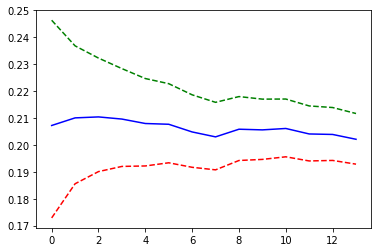

In [52]:
plt.plot(control_cumulative.probability, color='blue')
plt.plot(control_cumulative.low, color='red', linestyle='--')
plt.plot(control_cumulative.up, color='green', linestyle='--');

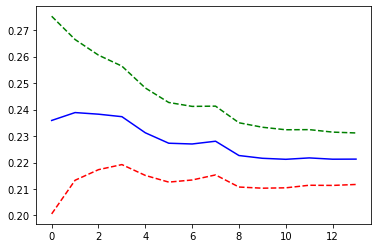

In [53]:
plt.plot(experimental_cumulative.probability, color='blue')
plt.plot(experimental_cumulative.low, color='red', linestyle='--')
plt.plot(experimental_cumulative.up, color='green', linestyle='--');